In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-08 04:55:28.678831: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-08 04:55:30.870176: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-08 04:55:30.914050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 04:55:30.914099: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 04:55:30.926846: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 04:55:30.926910: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-08 04:55:30.934626: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

ukdale_gen_GASF_60m_300S0X_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/ukdale/TL/ukdale_82_refit, iawe, eco, redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data ukdale training on model refit seed 82
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930
loading model
compling TL model..


2022-02-08 04:55:43.779325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 04:55:43.787293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-08 04:55:43.790848: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 04:55:44.672370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-08 04:55:44.672406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-08 04:55:44.672413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-08 04:55:44.673001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-08 04:55:45.282752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 04:55:45.300509: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/20


2022-02-08 04:55:45.813507: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-08 04:55:46.554510: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-08 04:55:47.422974: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 04:55:48.203797: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1874/1874 - 96s - loss: 1.1896 - accuracy: 0.6155
Epoch 2/20
1874/1874 - 93s - loss: 0.8951 - accuracy: 0.7063
Epoch 3/20
1874/1874 - 93s - loss: 0.8040 - accuracy: 0.7362
Epoch 4/20
1874/1874 - 93s - loss: 0.7577 - accuracy: 0.7499
Epoch 5/20
1874/1874 - 93s - loss: 0.7158 - accuracy: 0.7648
Epoch 6/20
1874/1874 - 93s - loss: 0.6852 - accuracy: 0.7764
Epoch 7/20
1874/1874 - 93s - loss: 0.6624 - accuracy: 0.7830
Epoch 8/20
1874/1874 - 92s - loss: 0.6458 - accuracy: 0.7893
Epoch 9/20
1874/1874 - 92s - loss: 0.6245 - accuracy: 0.7940
Epoch 10/20
1874/1874 - 93s - loss: 0.6094 - accuracy: 0.8013
Epoch 11/20
1874/1874 - 92s - loss: 0.5949 - accuracy: 0.8058
Epoch 12/20
1874/1874 - 92s - loss: 0.5861 - accuracy: 0.8091
Epoch 13/20
1874/1874 - 92s - loss: 0.5715 - accuracy: 0.8110
Epoch 14/20
1874/1874 - 92s - loss: 0.5609 - accuracy: 0.8163
Epoch 15/20
1874/1874 - 92s - loss: 0.5502 - accuracy: 0.8183
Epoch 16/20
1874/1874 - 92s - loss: 0.5442 - accuracy: 0.8231
Epoch 17/20
1874/1874 - 92s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 95s - loss: 2.2823 - accuracy: 0.2618
Epoch 2/20
1874/1874 - 93s - loss: 1.9527 - accuracy: 0.3174
Epoch 3/20
1874/1874 - 92s - loss: 1.6808 - accuracy: 0.4187
Epoch 4/20
1874/1874 - 92s - loss: 1.5589 - accuracy: 0.4591
Epoch 5/20
1874/1874 - 92s - loss: 1.4900 - accuracy: 0.4799
Epoch 6/20
1874/1874 - 92s - loss: 1.4505 - accuracy: 0.4950
Epoch 7/20
1874/1874 - 92s - loss: 1.4134 - accuracy: 0.5021
Epoch 8/20
1874/1874 - 92s - loss: 1.3641 - accuracy: 0.5200
Epoch 9/20
1874/1874 - 92s - loss: 1.3214 - accuracy: 0.5362
Epoch 10/20
1874/1874 - 92s - loss: 1.2977 - accuracy: 0.5484
Epoch 11/20
1874/1874 - 92s - loss: 1.2665 - accuracy: 0.5602
Epoch 12/20
1874/1874 - 92s - loss: 1.2427 - accuracy: 0.5699
Epoch 13/20
1874/1874 - 92s - loss: 1.2295 - accuracy: 0.5745
Epoch 14/20
1874/1874 - 92s - loss: 1.2057 - accuracy: 0.5849
Epoch 15/20
1874/1874 - 92s - loss: 1.1944 - accuracy: 0.5911
Epoch 16/20
1874/1874 - 92s - loss: 1.1840 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 1.8063 - accuracy: 0.4201
Epoch 2/20
1874/1874 - 92s - loss: 1.3819 - accuracy: 0.5466
Epoch 3/20
1874/1874 - 92s - loss: 1.2312 - accuracy: 0.5921
Epoch 4/20
1874/1874 - 92s - loss: 1.1496 - accuracy: 0.6194
Epoch 5/20
1874/1874 - 92s - loss: 1.0862 - accuracy: 0.6345
Epoch 6/20
1874/1874 - 92s - loss: 1.0558 - accuracy: 0.6455
Epoch 7/20
1874/1874 - 92s - loss: 1.0044 - accuracy: 0.6641
Epoch 8/20
1874/1874 - 92s - loss: 0.9674 - accuracy: 0.6750
Epoch 9/20
1874/1874 - 92s - loss: 0.9426 - accuracy: 0.6819
Epoch 10/20
1874/1874 - 92s - loss: 0.9112 - accuracy: 0.6920
Epoch 11/20
1874/1874 - 92s - loss: 0.8957 - accuracy: 0.6987
Epoch 12/20
1874/1874 - 92s - loss: 0.8688 - accuracy: 0.7086
Epoch 13/20
1874/1874 - 92s - loss: 0.8538 - accuracy: 0.7140
Epoch 14/20
1874/1874 - 92s - loss: 0.8449 - accuracy: 0.7177
Epoch 15/20
1874/1874 - 92s - loss: 0.8211 - accuracy: 0.7217
Epoch 16/20
1874/1874 - 92s - loss: 0.8182 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 95s - loss: 2.5314 - accuracy: 0.0825
Epoch 2/20
1874/1874 - 95s - loss: 2.4854 - accuracy: 0.0816
Epoch 3/20
1874/1874 - 94s - loss: 2.4853 - accuracy: 0.0695
Epoch 4/20
1874/1874 - 94s - loss: 2.4853 - accuracy: 0.0799
Epoch 5/20
1874/1874 - 93s - loss: 2.4853 - accuracy: 0.0711
Epoch 6/20
1874/1874 - 94s - loss: 2.4853 - accuracy: 0.0612
Epoch 7/20
1874/1874 - 93s - loss: 2.4853 - accuracy: 0.0758
Epoch 8/20
1874/1874 - 94s - loss: 2.4854 - accuracy: 0.0899
Epoch 9/20
1874/1874 - 94s - loss: 2.4853 - accuracy: 0.0774
Epoch 10/20
1874/1874 - 95s - loss: 2.4853 - accuracy: 0.0703
Epoch 11/20
1874/1874 - 93s - loss: 2.4853 - accuracy: 0.0740
Epoch 12/20
1874/1874 - 94s - loss: 2.4852 - accuracy: 0.0674
Epoch 13/20
1874/1874 - 94s - loss: 2.4854 - accuracy: 0.0750
Epoch 14/20
1874/1874 - 93s - loss: 2.4853 - accuracy: 0.0700
Epoch 15/20
1874/1874 - 94s - loss: 2.4853 - accuracy: 0.0659
Epoch 16/20
1874/1874 - 94s - loss: 2.4853 - a

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


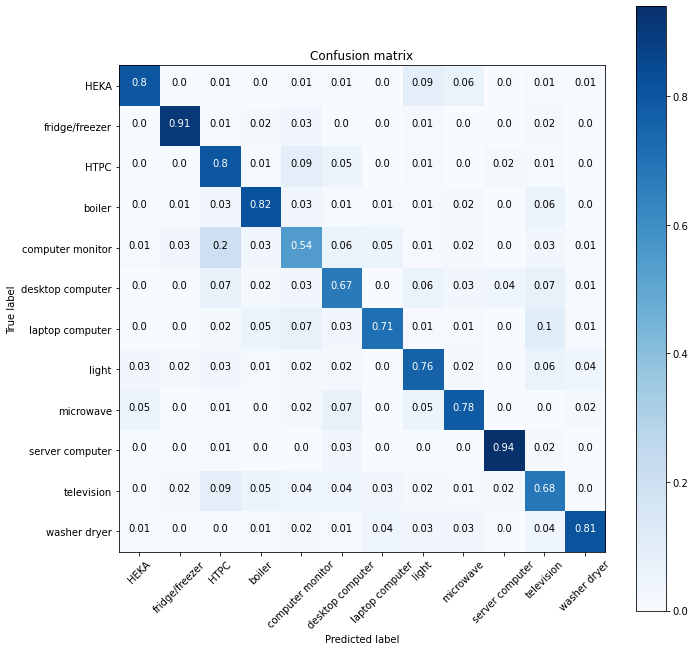

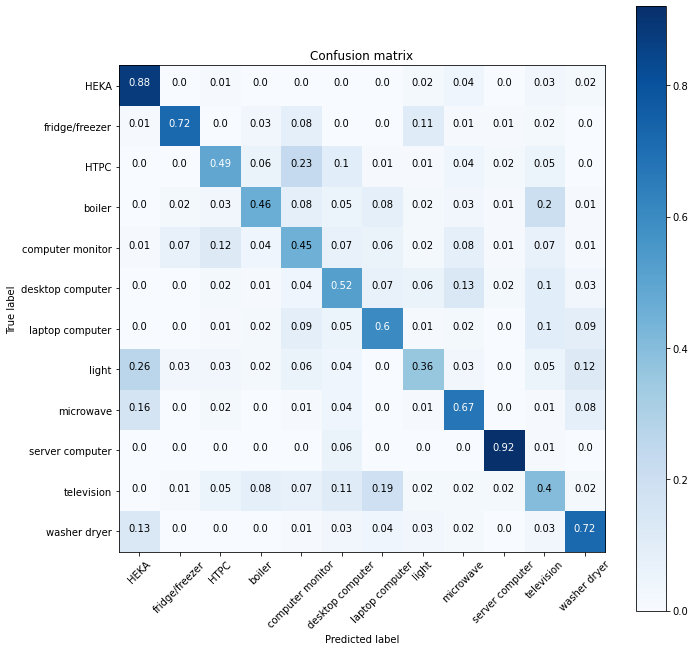

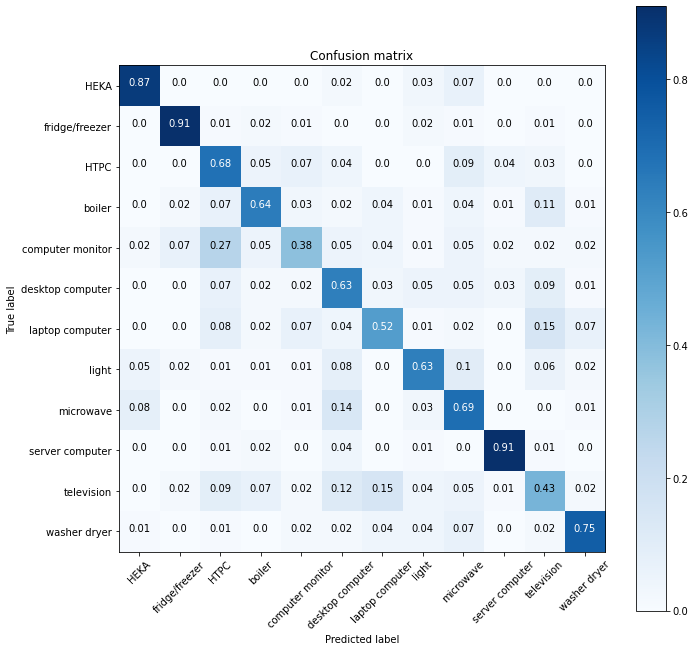

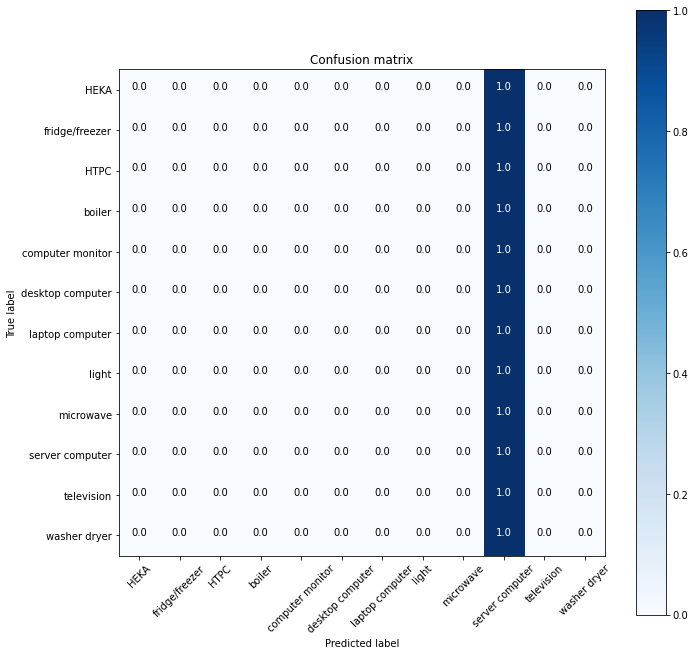

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()